In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal
import os
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn


### Data Processing 

In [2]:
# Import data from training & testing dataset
training_csv_file = 'dataset_2020_training.csv'
testing_csv_file = 'dataset_2020_testing1.csv'
training_set = pd.read_csv(training_csv_file, header=0)
testing_set = pd.read_csv(testing_csv_file, header=0)

#The output is: knee/ankle angle/torque l/r
out_num = 8

#Get the label
Label_df = pd.read_csv(training_csv_file, header=0, nrows = 1)
Label= Label_df.columns.values
output_label = np.array(Label[-out_num:])

#Get the values and convert to float type
training_values = training_set.values
testing_values = testing_set.values
time_train = training_values[:,0]
time_test  = testing_values[:,0]
training_data = training_values[:,1:].astype('float32')
testing_data = testing_values[:,1:].astype('float32')

In [3]:
def get_scaler(ndarray):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(ndarray)
    return scaler

In [4]:
#Get scaler for inputs/outputs
X_scaler_training = get_scaler(training_data[:,:98])
Y_scaler_training = get_scaler(training_data[:,-8:])
X_scaler_testing = get_scaler(testing_data[:,:98])
Y_scaler_testing = get_scaler(testing_data[:,-8:])


X_train = X_scaler_training.transform(training_data[:,:98])
Y_train = Y_scaler_training.transform(training_data[:,-8:])
X_test = X_scaler_testing.transform(testing_data[:,:98])
Y_test = Y_scaler_testing.transform(testing_data[:,-8:])

#Get scaler for the whole training data
train_data_scaler = get_scaler(training_data)
test_data_scaler = get_scaler(testing_data)

#Transform training data into scaled data and tensor data type
train_data_normalized = train_data_scaler.transform(training_data)
test_data_normalized =test_data_scaler.transform(testing_data)



In [5]:
def reshape(A, timesteps):
    return A.reshape(int(A.shape[0] / timesteps), timesteps, A.shape[1])

#Return tupple containing inputs and labels
def create_inout_sequences(input_data, size, out_num, time_steps):
    sequence = []
    outs =  []
    L = len(input_data)
    for i in range(L-time_steps):
        seq = input_data[i:i+time_steps,:size]
        label = input_data[i:i+time_steps,-out_num:]
        sequence.append(seq)
        outs.append(label)
    sequence = np.array(sequence)
    outs = np.array(outs)
    return sequence,outs

In [6]:
train_input, train_output = create_inout_sequences(train_data_normalized, 98, 8, 50)
test_input, test_output = create_inout_sequences(test_data_normalized, 98, 8, 50)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.from_numpy(train_input), torch.from_numpy(train_output))
val_data = TensorDataset(torch.from_numpy(test_input), torch.from_numpy(test_output))
test_data = TensorDataset(torch.from_numpy(test_input), torch.from_numpy(test_output))

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=1)

(2950, 50, 8)


### Model 

In [8]:
import torch
import torch.nn as nn

class Model(nn.Module):

    def __init__(self, input_dim = 98, 
                 hidden_dim = 256, 
                 output_dim=8,
                 num_layers=3,
                 drop_prob=0.3):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, 
                            num_layers, dropout=drop_prob, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self, batch_size=8):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.reshape(-1, self.hidden_dim)
        out = self.linear(lstm_out)
        
        out = out.view(-1, out.size(-1))    
        # Only take the output from the final timetep
        return out, hidden

### Training Model

In [48]:
lr=0.002
model = Model()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 50

best_val_loss = 1000
for epoch in range(num_epochs):
    train_loss_epoch = 0.0
    
    # train
    for X, Y in train_loader:
        # zero grad
        model.zero_grad()
        
        # forward
        Y = Y.view(-1, 8)
        Y_pred, _ = model(X)
        
        # compute loss
        loss_batch = loss_fn(Y, Y_pred)
        train_loss_epoch += loss_batch * Y_pred.size(0)
        
        # backward
        loss_batch.backward()

        # optimize
        optimizer.step()
    
    val_loss_epoch = 0.0
    # validation
    for X, Y in test_loader:
        
        # forward
        Y = Y.view(-1, 8)
        Y_pred, _ = model(X)

        # compute loss
        loss_batch = loss_fn(Y, Y_pred)
        val_loss_epoch += loss_batch * Y_pred.size(0)
    
    time_steps = 50
    train_loss_epoch = train_loss_epoch / (len(train_data)*time_steps)
    val_loss_epoch = val_loss_epoch / (len(test_data)*time_steps)
    print("Epoch: %2d, train loss: %.4f, val loss: %.4f" % (epoch, 
                                                            train_loss_epoch.item(),
                                                            val_loss_epoch.item()))
    
    # save model
    if val_loss_epoch < best_val_loss:
        print("Save best model at epoch %2d" % epoch)
        torch.save(model.state_dict(), "best_model1.pth")
        best_val_loss = val_loss_epoch

Epoch:  0, train loss: 0.1287, val loss: 0.0752
Save best model at epoch  0
Epoch:  1, train loss: 0.0594, val loss: 0.0500
Save best model at epoch  1
Epoch:  2, train loss: 0.0348, val loss: 0.0443
Save best model at epoch  2
Epoch:  3, train loss: 0.0303, val loss: 0.0497
Epoch:  4, train loss: 0.0273, val loss: 0.0414
Save best model at epoch  4
Epoch:  5, train loss: 0.0198, val loss: 0.0300
Save best model at epoch  5
Epoch:  6, train loss: 0.0169, val loss: 0.0289
Save best model at epoch  6
Epoch:  7, train loss: 0.0167, val loss: 0.0330
Epoch:  8, train loss: 0.0164, val loss: 0.0315
Epoch:  9, train loss: 0.0140, val loss: 0.0330
Epoch: 10, train loss: 0.0130, val loss: 0.0312
Epoch: 11, train loss: 0.0120, val loss: 0.0290
Epoch: 12, train loss: 0.0111, val loss: 0.0288
Save best model at epoch 12
Epoch: 13, train loss: 0.0112, val loss: 0.0272
Save best model at epoch 13
Epoch: 14, train loss: 0.0114, val loss: 0.0251
Save best model at epoch 14
Epoch: 15, train loss: 0.010

### Performance Evaluation

In [88]:
#Load the trained model
model = Model()
model.load_state_dict(torch.load("best_model1.pth"))

<All keys matched successfully>

In [89]:
#Define functions used for evaluation phase
legends = ['Original','Predicted']
#RMSE calculation
def rmse_cal(Y_pred,Y):
    size = Y_pred.shape[0]
    value = np.sqrt(np.sum((Y_pred - Y)**2)/size)
    return value

#VAF calculation
def vaf_cal(Y_pred,Y):
    size = Y_pred.shape[0]
    value = 1 - np.sum((Y_pred - Y)**2)/np.sum(Y**2)
    return value

#Perform prediction based on the trained model
def online_pred(model, X, hidden_in):
    # X = [1, 1, 98]
    Y_pred, hidden = model(X, hidden_in)
    return Y_pred, hidden

#Perform the evaluation and plot graphs
def evaluation(time, Y, Y_pred, split, label):    
    frame_size = 600
    for col in range(8):
        rmse = np.round(rmse_cal(Y[:frame_size, col],Y_pred[:frame_size, col]),2)
        vaf = np.round(vaf_cal(Y[:frame_size, col],Y_pred[:frame_size, col]),5)
        if col == 0 or col == 1 or col == 4 or col == 5:
            y_label = 'Degree'
            unit = '\xB0'
        else:
            y_label = 'Nm'
            unit = ' Nm'
        print('vaf' + f'({label[col]}) =', vaf)
        print('RMSE' + f'({label[col]}) = {rmse}' + unit)
        plt.plot(time[:frame_size], Y[:frame_size, col], 'r')
        plt.plot(time[:frame_size], Y_pred[:frame_size, col], 'b')
        plt.legend(legends, loc = 'upper right')
        plt.xlabel('Time [s]')
        plt.ylabel(y_label)
        #title = label[col] + f' (RMSE = {rmse}' + unit + ')'
        plt.title(label[col])
        plt.savefig('plots/' + split + f'_{label[col]}.pdf')
        plt.show()
        
#Get the predicted values from the test dataset
def get_prediction(inputs):
    hidden = None
    Y_preds = []
    with torch.no_grad():
        for x in inputs:
            X = torch.tensor(x).view(1,1,-1)
            y_pred, hidden = online_pred(model, X , hidden)
            y_pred = Y_scaler_testing.inverse_transform(y_pred).reshape(-1)
            Y_preds.append(y_pred)
        Y_preds = np.array(Y_preds)
    return (Y_preds)

vaf(knee_angle_r) = 0.99551
RMSE(knee_angle_r) = 4.59°


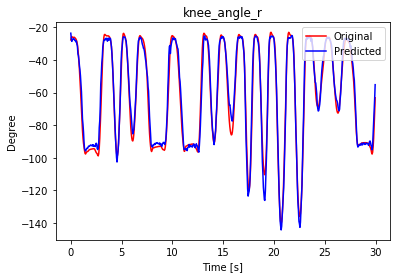

vaf(ankle_angle_r) = 0.97714
RMSE(ankle_angle_r) = 3.3°


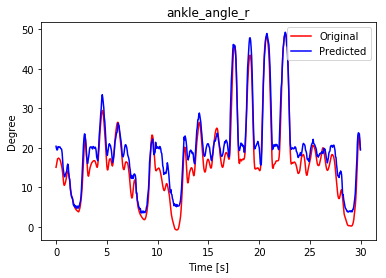

vaf(knee_angle_r_moment) = 0.69998
RMSE(knee_angle_r_moment) = 11.08 Nm


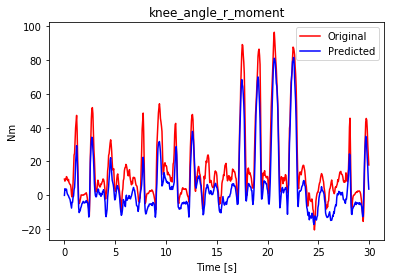

vaf(ankle_angle_r_moment) = 0.95244
RMSE(ankle_angle_r_moment) = 5.36 Nm


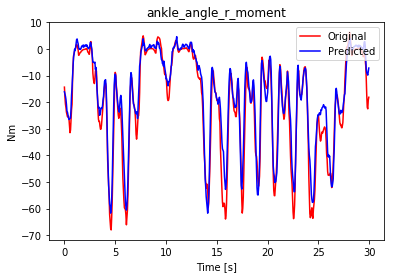

vaf(knee_angle_l) = 0.99596
RMSE(knee_angle_l) = 4.33°


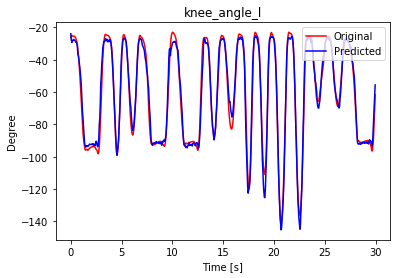

vaf(ankle_angle_l) = 0.98774
RMSE(ankle_angle_l) = 2.32°


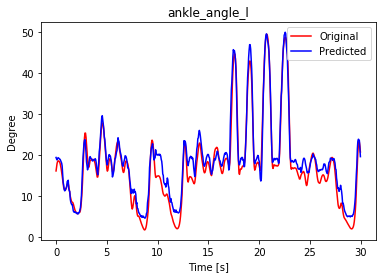

vaf(knee_angle_l_moment) = 0.90104
RMSE(knee_angle_l_moment) = 6.67 Nm


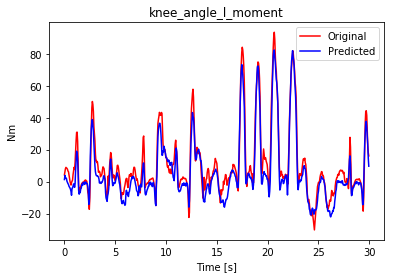

vaf(ankle_angle_l_moment) = 0.9759
RMSE(ankle_angle_l_moment) = 4.92 Nm


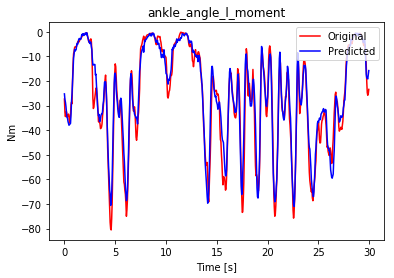

In [90]:
#Execute the evaluation
Y_test_preds = get_prediction(X_test)
evaluation(time_test, Y_scaler_testing.inverse_transform(Y_test),Y_test_preds,'test', label=output_label)